# Intro

本文为金融学主修本科毕业论文，主要运用EMD-LSTM对股价波动率进行预测，进而对VaR值进行估计预测。

在波动率预测方面，使用传统GARCH模型，单一LSTM模型与EMD-LSTM进行比对；

在VaR度量方面，使用GARCH模型对结果进行比较，Kupiec检验进行验证。

# Preperations

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime, timedelta
from scipy.stats import binom, chi2
from arch import arch_model
from arch.unitroot import ADF
from arch.unitroot import engle_granger
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.arima import ARIMA
from arch.univariate import ARCH, GARCH

from pylab import mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)
mpl.rcParams['font.sans-serif']=["SimSun"]

In [2]:
from PyEMD import EMD

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

from sklearn.model_selection import train_test_split

## Import Data

In [3]:
path_file='...'

In [4]:
li = pd.read_csv('LI.csv', usecols=lambda col: col != 'Datetime')

## Log returns and Concatenate

In [5]:
mean = li['Close'].pct_change().mean()
li['return'] = li['Close'].pct_change().apply(lambda x: mean if pd.isna(x) else round(np.log(1 + x), 6))

In [6]:
li.head()

,Open,High,Low,Close,Adj Close,Volume,return
0,32.000000,32.055000,31.980000,32.049999,32.049999,437513,0.000026
1,32.022999,32.320000,32.000000,32.270000,32.270000,59031,0.006841
2,32.248699,32.680000,32.209999,32.645000,32.645000,118252,0.011554
3,32.645000,32.679901,32.469601,32.549999,32.549999,88319,-0.002914
4,32.529999,32.639999,32.500198,32.619999,32.619999,63858,0.002148


## Realized Volatilities

In [7]:
window_size = 5
li = li.astype(float)
# 计算历史波动率
li['rv'] = li.iloc[:, 2].rolling(window=window_size).std()
li['rv'] = li['rv']

In [8]:
li['rv'].fillna(li['rv'].mean(), inplace=True)

In [9]:
li.head()

,Open,High,Low,Close,Adj Close,Volume,return,rv
0,32.000000,32.055000,31.980000,32.049999,32.049999,437513.0,0.000026,0.038641
1,32.022999,32.320000,32.000000,32.270000,32.270000,59031.0,0.006841,0.038641
2,32.248699,32.680000,32.209999,32.645000,32.645000,118252.0,0.011554,0.038641
3,32.645000,32.679901,32.469601,32.549999,32.549999,88319.0,-0.002914,0.038641
4,32.529999,32.639999,32.500198,32.619999,32.619999,63858.0,0.002148,0.248091


D:\downloadposition\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


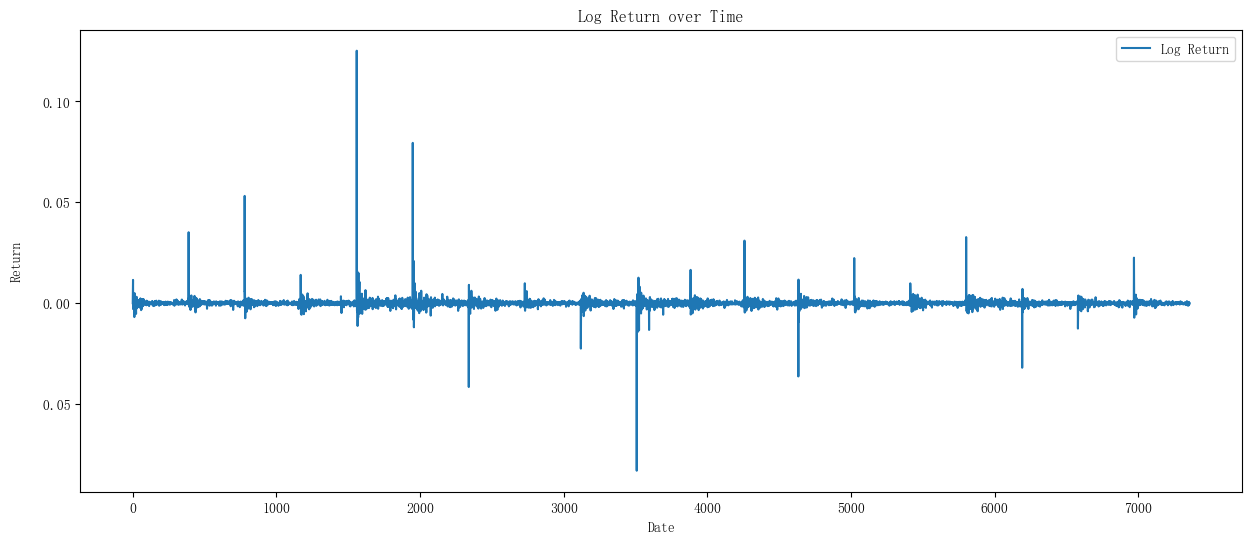

In [10]:
plt.figure(figsize=(15, 6))
plt.plot(li['return'], label='Log Return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Log Return over Time')
plt.legend()
plt.show()

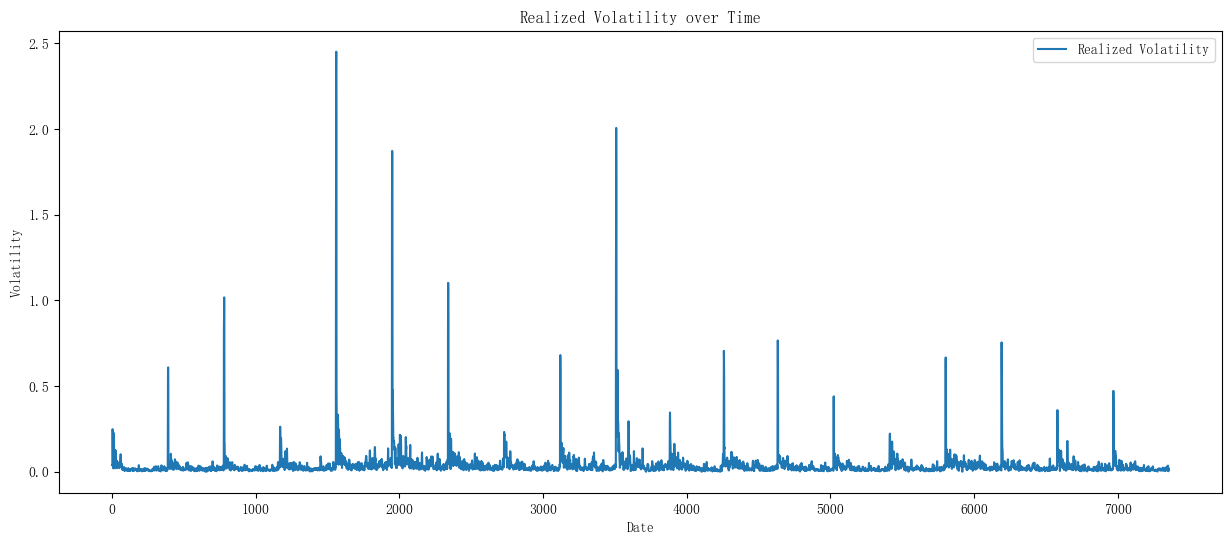

In [11]:
plt.figure(figsize=(15, 6))
plt.plot( li['rv'], label='Realized Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Realized Volatility over Time')
plt.legend()
plt.show()

# EMD-LSTM

## EMD

In [12]:
emd = EMD(n_imfs=7)
rv=np.array(li['rv'].tolist())
imfs = emd(rv)
residue = emd.residue

C:\Users\Yueying Huang\AppData\Local\Temp\ipykernel_720\2861570489.py:17: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()


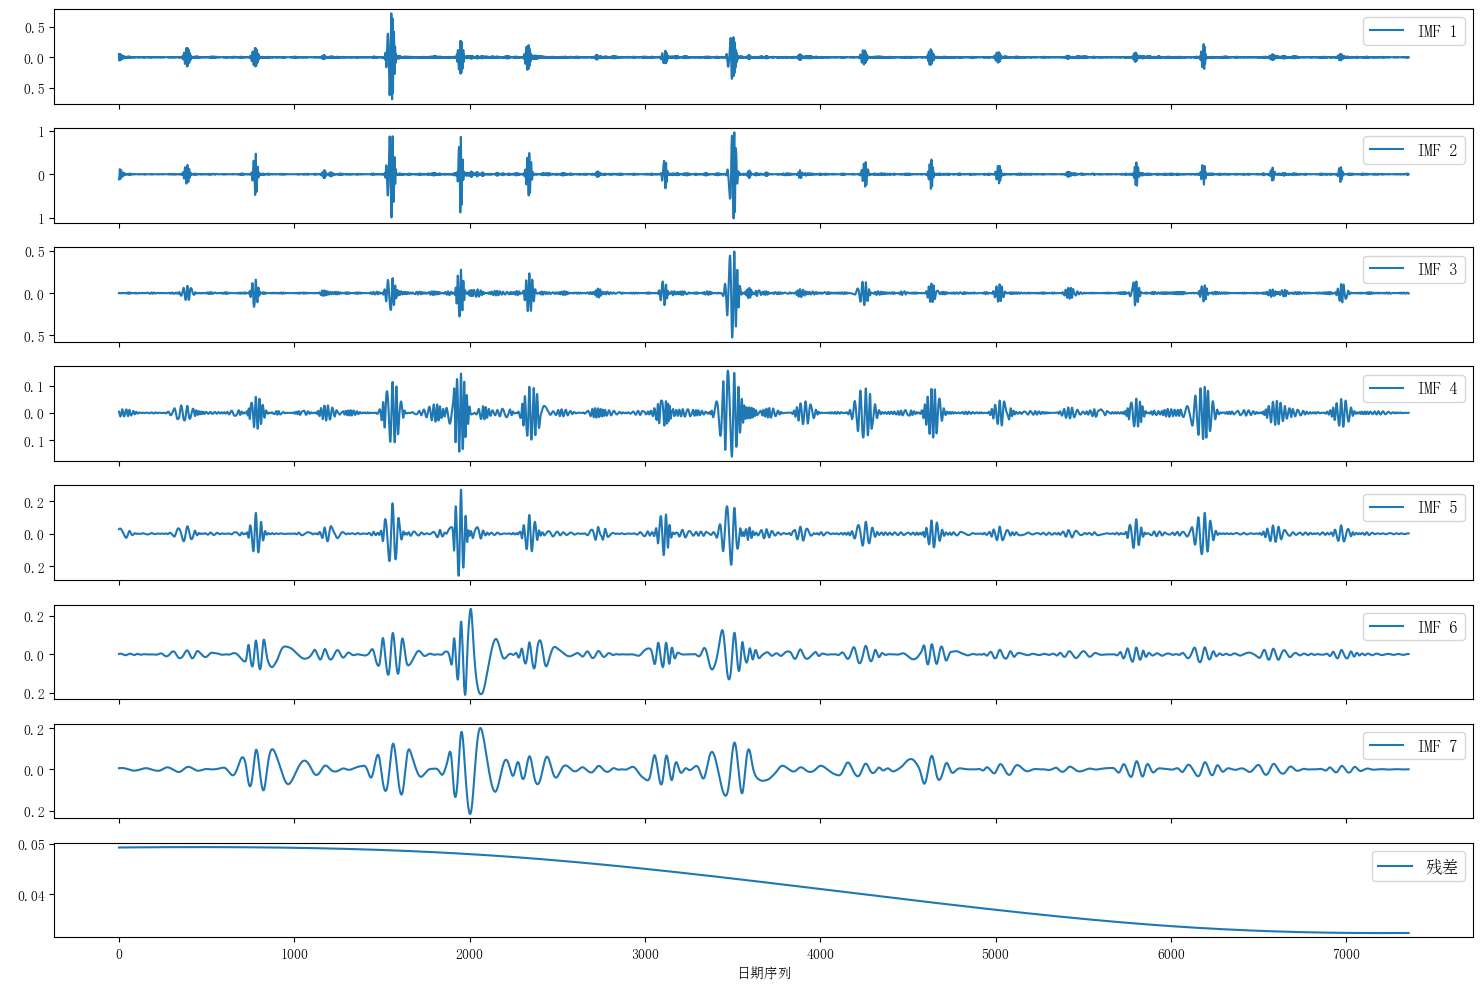

In [13]:
fig, axs = plt.subplots(nrows=8, ncols=1, figsize=(15, 10), sharex=True)

# 绘制 IMFs
for i, imf in enumerate(imfs[:7]):  # 限制绘制的 IMFs 数量为 7
    axs[i].plot(imf, label=f'IMF {i+1}')
    axs[i].set_ylabel('')  # 设置纵轴标签为空字符串
    axs[i].legend(fontsize='large')

# 绘制残差
axs[7].plot(residue, label='残差')
axs[7].set_ylabel('')
axs[7].legend()
axs[7].legend(fontsize='large')
# 设置 x 轴标签
axs[7].set_xlabel('日期序列')

plt.tight_layout()
plt.show()

In [14]:
imfs = imfs[:7]

In [15]:
imfs = pd.DataFrame(imfs.T, columns=[f'IMF_{i+1}' for i in range(7)])
residue = pd.DataFrame(residue, columns=['Residue'])

In [16]:
df = pd.concat([imfs, residue], axis=1)
df.head()

,IMF_1,IMF_2,IMF_3,IMF_4,IMF_5,IMF_6,IMF_7,Residue
0,0.051781,-0.118236,-0.001671,0.004438,0.028070,0.002409,0.005520,0.049261
1,0.055249,-0.120744,-0.002554,0.002896,0.028949,0.002801,0.005660,0.049261
2,0.028244,-0.093346,-0.001782,0.000415,0.029751,0.003149,0.005791,0.049261
3,-0.054384,-0.010551,-0.000062,-0.002611,0.030450,0.003450,0.005912,0.049262
4,0.053298,0.091641,0.001704,-0.005732,0.031020,0.003703,0.006024,0.049262


## LSTM

In [17]:
def get_imf(train_imfs, index):
    """
    获取指定 IMF 数据列

    train_imfs: DataFrame，包含 IMF 数据的 DataFrame
    index: int，IMF 编号
    
    返回：
    IMF 数据列
    """
    imf_column_name = f'IMF_{index}'
    return train_imfs[imf_column_name]

### Spliting dataset

In [18]:
train_imfs, test_imfs = train_test_split(imfs, test_size=0.2, shuffle=False)
train_residue, test_residue = train_test_split(residue, test_size=0.2, shuffle=False)

In [19]:
train_imfs.shape

(5885, 7)

In [20]:
test_imfs.shape

(1472, 7)

D:\downloadposition\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


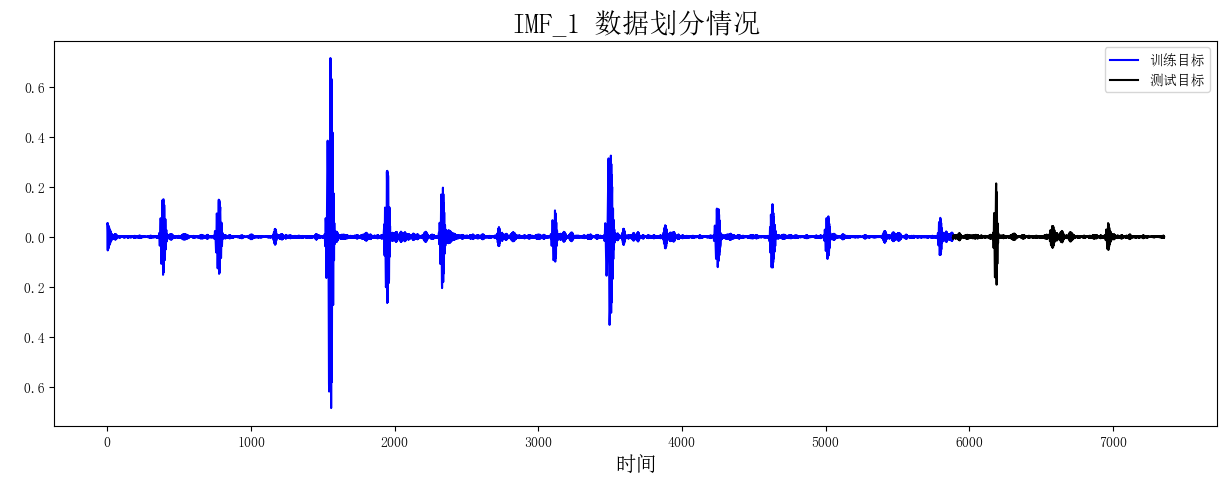

In [21]:
imf1 = get_imf(train_imfs, 1)
plt.figure(figsize=(15, 5))

plt.plot(np.arange(len(imf1)), imf1, color='blue', label='训练目标')

# 绘制测试目标
plt.plot(np.arange(len(train_imfs), len(train_imfs) + len(test_imfs)),
         test_imfs['IMF_1'], color='black', label='测试目标')

plt.title('IMF_1 数据划分情况', fontsize=20)
plt.xlabel('时间', fontsize=15)
plt.legend(loc='best')

# 设置 x 轴刻度间隔
locator = MultipleLocator(1000)
plt.gca().xaxis.set_major_locator(locator)
plt.show()

### Model training

In [22]:
model = Sequential()

# 添加LSTM层
model.add(LSTM(units=4, input_shape=(10, 1)))

# 添加一层线性网络得到最终输出
model.add(Dense(units=1, kernel_regularizer=l2(0.01)))  # 加入L2正则化

# 编译模型
optimizer = Adam()
model.compile(optimizer=optimizer, loss='mse')  # 使用均方误差作为损失函数

# 输出模型结构
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101 (404.00 Byte)
Trainable params: 101 (404.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### IMF1

In [23]:
imf1 = get_imf(train_imfs, 1)
imf1_test= get_imf(test_imfs, 1)

In [24]:
imf1_his=model.fit(imf1, np.roll(imf1, -1), epochs=100, batch_size=128)

Epoch 1/100

46/46 [==============================] - 7s 4ms/step - loss: 0.0177
Epoch 2/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 3/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0142
Epoch 4/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 5/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0114
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0103
Epoch 7/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 8/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0084
Epoch 9/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0076
Epoch 10/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0069
Epoch 11/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 12/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0058
Epoch 13/100
46/46 [================

In [25]:
imf1_pred= model.predict(imf1_test)

46/46 [==============================] - 1s 2ms/step


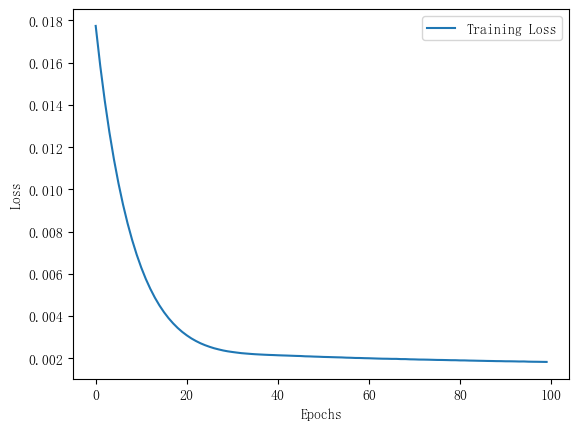

In [26]:
loss_1 = imf1_his.history['loss']
# 绘制训练曲线
plt.plot(loss_1, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
rmse1 = np.sqrt(mean_squared_error(imf1_test, imf1_pred))
mae1 = mean_absolute_error(imf1_test, imf1_pred)

# 输出评估指标
print("RMSE:", rmse1)
print("MAE:", mae1)

RMSE: [0.01821134 0.01833224 0.01850332 ... 0.0180325  0.01818894 0.01806715]
MAE: tf.Tensor([0.00706751 0.00740286 0.00787563 ... 0.00664127 0.00700791 0.00669645], shape=(1472,), dtype=float32)


#### IMF2

In [28]:
imf2 = get_imf(train_imfs, 2)
imf2_test = get_imf(test_imfs, 2)

In [29]:
imf2_his=model.fit(imf2, np.roll(imf2, -1), epochs=100, batch_size=128)

Epoch 1/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 2/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0040
Epoch 3/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0039
Epoch 4/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 5/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 7/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0037
Epoch 8/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0037
Epoch 9/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0037
Epoch 10/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0037
Epoch 11/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0037
Epoch 12/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0037
Epoch 13/100
46/46 [=================

In [30]:
imf2_pred= model.predict(imf2_test)

46/46 [==============================] - 0s 2ms/step


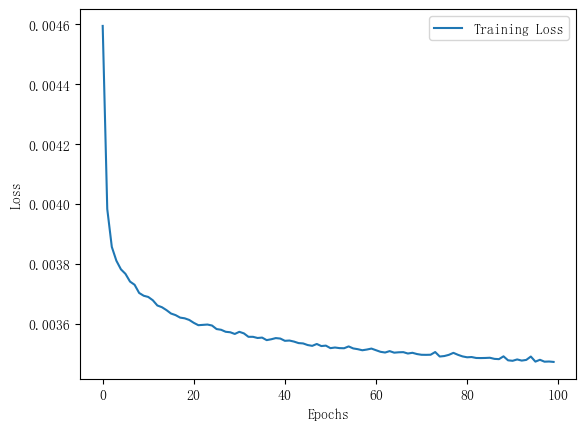

In [31]:
loss_2 = imf2_his.history['loss']
# 绘制训练曲线
plt.plot(loss_2, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
rmse2 = np.sqrt(mean_squared_error(imf2_test, imf2_pred))
mae2 = mean_absolute_error(imf2_test, imf2_pred)

# 输出评估指标
print("RMSE:", rmse2)
print("MAE:", mae2)

RMSE: [0.03106275 0.03072439 0.02744431 ... 0.03160559 0.02783332 0.02650288]
MAE: tf.Tensor([0.02044976 0.01985976 0.01313313 ... 0.02137267 0.01407923 0.01043017], shape=(1472,), dtype=float32)


#### IMF3

In [33]:
imf3 = get_imf(train_imfs, 3)
imf3_test = get_imf(test_imfs, 3)

In [34]:
imf3_his=model.fit(imf3, np.roll(imf3, -1), epochs=100, batch_size=128)

Epoch 1/100
46/46 [==============================] - 0s 4ms/step - loss: 9.0577e-04
Epoch 2/100
46/46 [==============================] - 0s 4ms/step - loss: 8.0851e-04
Epoch 3/100
46/46 [==============================] - 0s 4ms/step - loss: 7.7604e-04
Epoch 4/100
46/46 [==============================] - 0s 4ms/step - loss: 7.6466e-04
Epoch 5/100
46/46 [==============================] - 0s 4ms/step - loss: 7.5820e-04
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 7.5305e-04
Epoch 7/100
46/46 [==============================] - 0s 4ms/step - loss: 7.4783e-04
Epoch 8/100
46/46 [==============================] - 0s 4ms/step - loss: 7.4338e-04
Epoch 9/100
46/46 [==============================] - 0s 4ms/step - loss: 7.3900e-04
Epoch 10/100
46/46 [==============================] - 0s 4ms/step - loss: 7.3438e-04
Epoch 11/100
46/46 [==============================] - 0s 4ms/step - loss: 7.3049e-04
Epoch 12/100
46/46 [==============================] - 0s 4ms/step - loss: 

In [35]:
imf3_pred= model.predict(imf3_test)

46/46 [==============================] - 0s 3ms/step


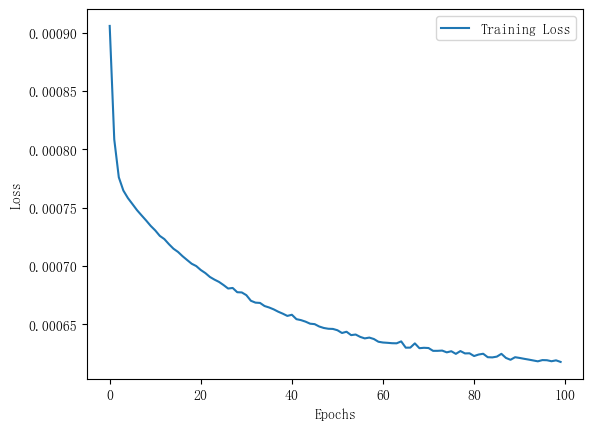

In [36]:
loss_3 = imf3_his.history['loss']
# 绘制训练曲线
plt.plot(loss_3, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
rmse3 = np.sqrt(mean_squared_error(imf3_test, imf3_pred))
mae3 = mean_absolute_error(imf3_test, imf3_pred)

# 输出评估指标
print("RMSE:", rmse3)
print("MAE:", mae3)

RMSE: [0.01943366 0.01850211 0.01793109 ... 0.01938924 0.01907307 0.01853164]
MAE: tf.Tensor([0.01242497 0.01064811 0.00928613 ... 0.01234529 0.01176824 0.01071   ], shape=(1472,), dtype=float32)


#### IMF4

In [38]:
imf4 = get_imf(train_imfs, 4)
imf4_test = get_imf(test_imfs, 4)

In [39]:
imf4_his=model.fit(imf4, np.roll(imf4, -1), epochs=100, batch_size=128)

Epoch 1/100
46/46 [==============================] - 0s 5ms/step - loss: 2.1903e-04
Epoch 2/100
46/46 [==============================] - 0s 5ms/step - loss: 1.9519e-04
Epoch 3/100
46/46 [==============================] - 0s 5ms/step - loss: 1.9338e-04
Epoch 4/100
46/46 [==============================] - 0s 4ms/step - loss: 1.9162e-04
Epoch 5/100
46/46 [==============================] - 0s 4ms/step - loss: 1.9031e-04
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 1.8889e-04
Epoch 7/100
46/46 [==============================] - 0s 4ms/step - loss: 1.8743e-04
Epoch 8/100
46/46 [==============================] - 0s 5ms/step - loss: 1.8608e-04
Epoch 9/100
46/46 [==============================] - 0s 4ms/step - loss: 1.8491e-04
Epoch 10/100
46/46 [==============================] - 0s 5ms/step - loss: 1.8354e-04
Epoch 11/100
46/46 [==============================] - 0s 4ms/step - loss: 1.8226e-04
Epoch 12/100
46/46 [==============================] - 0s 5ms/step - loss: 

In [40]:
imf4_pred= model.predict(imf4_test)

46/46 [==============================] - 0s 3ms/step


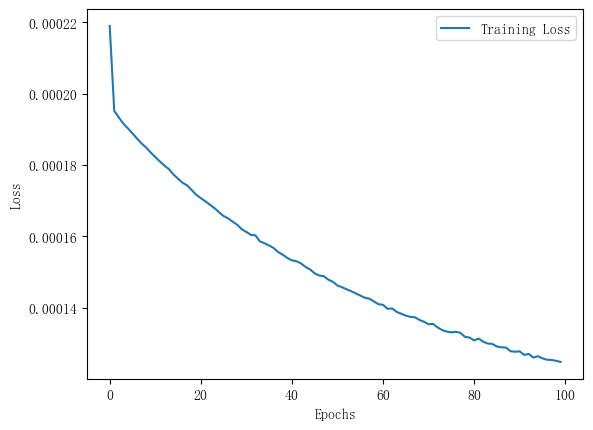

In [41]:
loss_4 = imf4_his.history['loss']
# 绘制训练曲线
plt.plot(loss_4, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
rmse4 = np.sqrt(mean_squared_error(imf4_test, imf4_pred))
mae4 = mean_absolute_error(imf4_test, imf4_pred)

# 输出评估指标
print("RMSE:", rmse4)
print("MAE:", mae4)

RMSE: [0.01980075 0.01990882 0.02017358 ... 0.01980236 0.019802   0.01980095]
MAE: tf.Tensor([0.01121728 0.01145279 0.01205247 ... 0.01121731 0.01121719 0.01121718], shape=(1472,), dtype=float32)


#### IMF5

In [43]:
imf5 = get_imf(train_imfs, 5)
imf5_test = get_imf(test_imfs, 5)

In [44]:
imf5_his=model.fit(imf5, np.roll(imf5, -1), epochs=100, batch_size=128)

Epoch 1/100
46/46 [==============================] - 0s 4ms/step - loss: 1.8493e-04
Epoch 2/100
46/46 [==============================] - 0s 4ms/step - loss: 1.8327e-04
Epoch 3/100
46/46 [==============================] - 0s 4ms/step - loss: 1.8500e-04
Epoch 4/100
46/46 [==============================] - 0s 4ms/step - loss: 1.8490e-04
Epoch 5/100
46/46 [==============================] - 0s 4ms/step - loss: 1.8338e-04
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 1.8322e-04
Epoch 7/100
46/46 [==============================] - 0s 4ms/step - loss: 1.8278e-04
Epoch 8/100
46/46 [==============================] - 0s 4ms/step - loss: 1.8246e-04
Epoch 9/100
46/46 [==============================] - 0s 4ms/step - loss: 1.8264e-04
Epoch 10/100
46/46 [==============================] - 0s 4ms/step - loss: 1.8172e-04
Epoch 11/100
46/46 [==============================] - 0s 5ms/step - loss: 1.8280e-04
Epoch 12/100
46/46 [==============================] - 0s 4ms/step - loss: 

In [45]:
imf5_pred= model.predict(imf5_test)

46/46 [==============================] - 0s 3ms/step


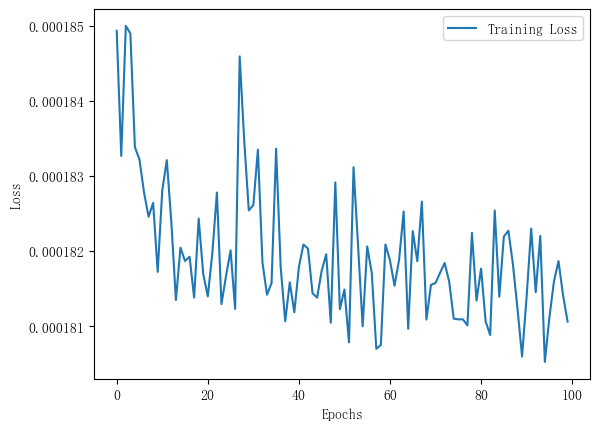

In [46]:
loss_5 = imf5_his.history['loss']
# 绘制训练曲线
plt.plot(loss_5, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
rmse5 = np.sqrt(mean_squared_error(imf5_test, imf5_pred))
mae5 = mean_absolute_error(imf5_test, imf5_pred)

# 输出评估指标
print("RMSE:", rmse5)
print("MAE:", mae5)

RMSE: [0.02528197 0.02551849 0.02569037 ... 0.02387833 0.0238603  0.02383519]
MAE: tf.Tensor([0.01640764 0.01687605 0.01720397 ... 0.01261535 0.01256934 0.0125058 ], shape=(1472,), dtype=float32)


#### IMF6

In [48]:
imf6 = get_imf(train_imfs, 6)
imf6_test = get_imf(test_imfs, 6)

In [49]:
imf6_his=model.fit(imf6, np.roll(imf6, -1), epochs=100, batch_size=128)

Epoch 1/100
46/46 [==============================] - 0s 4ms/step - loss: 1.7434e-04
Epoch 2/100
46/46 [==============================] - 0s 4ms/step - loss: 1.7225e-04
Epoch 3/100
46/46 [==============================] - 0s 4ms/step - loss: 1.7321e-04
Epoch 4/100
46/46 [==============================] - 0s 3ms/step - loss: 1.7199e-04
Epoch 5/100
46/46 [==============================] - 0s 4ms/step - loss: 1.7212e-04
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 1.7154e-04
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 1.7062e-04
Epoch 8/100
46/46 [==============================] - 0s 3ms/step - loss: 1.7160e-04
Epoch 9/100
46/46 [==============================] - 0s 4ms/step - loss: 1.7220e-04
Epoch 10/100
46/46 [==============================] - 0s 4ms/step - loss: 1.7298e-04
Epoch 11/100
46/46 [==============================] - 0s 4ms/step - loss: 1.7140e-04
Epoch 12/100
46/46 [==============================] - 0s 4ms/step - loss: 

In [50]:
imf6_pred= model.predict(imf6_test)

46/46 [==============================] - 0s 3ms/step


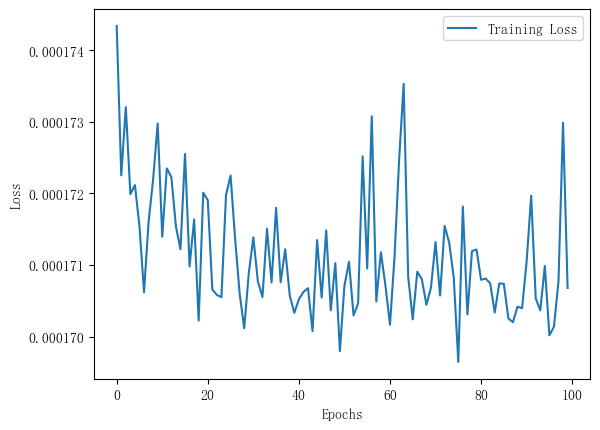

In [51]:
loss_6 = imf6_his.history['loss']
# 绘制训练曲线
plt.plot(loss_6, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [52]:
rmse6 = np.sqrt(mean_squared_error(imf6_test, imf6_pred))
mae6 = mean_absolute_error(imf6_test, imf6_pred)

# 输出评估指标
print("RMSE:", rmse6)
print("MAE:", mae6)

RMSE: [0.01114474 0.01105684 0.01108138 ... 0.01174582 0.01174815 0.01174071]
MAE: tf.Tensor([0.00748312 0.00740279 0.00746713 ... 0.00827666 0.00827979 0.00826977], shape=(1472,), dtype=float32)


#### IMF7

In [53]:
imf7 = get_imf(train_imfs, 7)
imf7_test = get_imf(test_imfs, 7)

In [54]:
imf7_his=model.fit(imf7, np.roll(imf7, -1), epochs=100, batch_size=128)

Epoch 1/100
46/46 [==============================] - 0s 4ms/step - loss: 1.6247e-04
Epoch 2/100
46/46 [==============================] - 0s 4ms/step - loss: 1.6087e-04
Epoch 3/100
46/46 [==============================] - 0s 4ms/step - loss: 1.5859e-04
Epoch 4/100
46/46 [==============================] - 0s 4ms/step - loss: 1.5865e-04
Epoch 5/100
46/46 [==============================] - 0s 4ms/step - loss: 1.5789e-04
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 1.5749e-04
Epoch 7/100
46/46 [==============================] - 0s 4ms/step - loss: 1.5645e-04
Epoch 8/100
46/46 [==============================] - 0s 4ms/step - loss: 1.5645e-04
Epoch 9/100
46/46 [==============================] - 0s 4ms/step - loss: 1.5549e-04
Epoch 10/100
46/46 [==============================] - 0s 4ms/step - loss: 1.5661e-04
Epoch 11/100
46/46 [==============================] - 0s 4ms/step - loss: 1.5591e-04
Epoch 12/100
46/46 [==============================] - 0s 4ms/step - loss: 

In [55]:
imf7_pred= model.predict(imf7_test)

46/46 [==============================] - 0s 3ms/step


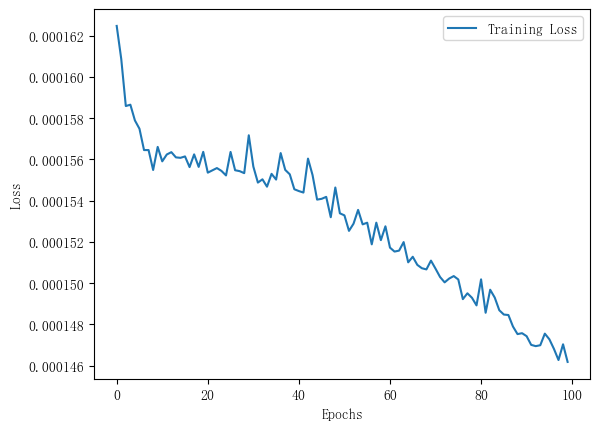

In [56]:
loss_7 = imf7_his.history['loss']
# 绘制训练曲线
plt.plot(loss_7, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:
rmse7 = np.sqrt(mean_squared_error(imf7_test, imf7_pred))
mae7 = mean_absolute_error(imf7_test, imf7_pred)

# 输出评估指标
print("RMSE:", rmse7)
print("MAE:", mae7)

RMSE: [0.01128747 0.01098338 0.0110285  ... 0.01113242 0.01112847 0.01112269]
MAE: tf.Tensor([0.00797117 0.00752186 0.00786863 ... 0.00773754 0.00773147 0.0077225 ], shape=(1472,), dtype=float32)


#### Residue

In [58]:
res_his=model.fit(train_residue, np.roll(train_residue, -1), epochs=100, batch_size=128)

Epoch 1/100
46/46 [==============================] - 3s 4ms/step - loss: 6.1199e-05
Epoch 2/100
46/46 [==============================] - 0s 4ms/step - loss: 2.6671e-05
Epoch 3/100
46/46 [==============================] - 0s 4ms/step - loss: 2.1751e-05
Epoch 4/100
46/46 [==============================] - 0s 4ms/step - loss: 2.0494e-05
Epoch 5/100
46/46 [==============================] - 0s 4ms/step - loss: 1.9944e-05
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 2.0137e-05
Epoch 7/100
46/46 [==============================] - 0s 4ms/step - loss: 1.9837e-05
Epoch 8/100
46/46 [==============================] - 0s 4ms/step - loss: 1.9834e-05
Epoch 9/100
46/46 [==============================] - 0s 4ms/step - loss: 1.9636e-05
Epoch 10/100
46/46 [==============================] - 0s 4ms/step - loss: 1.9564e-05
Epoch 11/100
46/46 [==============================] - 0s 4ms/step - loss: 1.9691e-05
Epoch 12/100
46/46 [==============================] - 0s 4ms/step - loss: 

In [59]:
res_pred= model.predict(test_residue)

46/46 [==============================] - 1s 3ms/step


D:\downloadposition\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


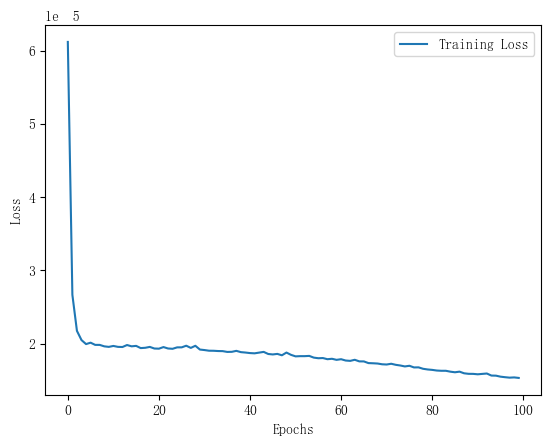

In [60]:
loss_res = res_his.history['loss']
# 绘制训练曲线
plt.plot(loss_res, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [61]:
rmse_res = np.sqrt(mean_squared_error(test_residue, res_pred))
mae_res = mean_absolute_error(test_residue, res_pred)

# 输出评估指标
print("RMSE:", rmse_res)
print("MAE:", mae_res)

RMSE: [0.00605738 0.00605892 0.00606045 ... 0.00701938 0.00701923 0.00701907]
MAE: tf.Tensor([0.00605738 0.00605892 0.00606045 ... 0.00701938 0.00701923 0.00701907], shape=(1472,), dtype=float32)


## Prediction Result

In [62]:
sum_pred = imf1_pred + imf2_pred + imf3_pred + imf4_pred + imf5_pred + imf6_pred + imf7_pred + res_pred
sum_test = imf1_test + imf2_test + imf3_test + imf4_test + imf5_test + imf6_test + imf7_test + test_residue.squeeze()

In [63]:
sum_pred = pd.DataFrame({'pred': sum_pred.reshape(-1)})
sum_test = pd.DataFrame({'test': sum_test}).reset_index(drop=True)
comb_emd = pd.concat([sum_pred, sum_test], axis=1)

comb_emd.head()

,pred,test
0,0.007657,0.001928
1,0.008532,0.001744
2,0.019797,0.011144
3,0.038112,0.037185
4,0.044815,0.044995


In [64]:
li_rv_comp = li['rv'][5885:].reset_index(drop=True)

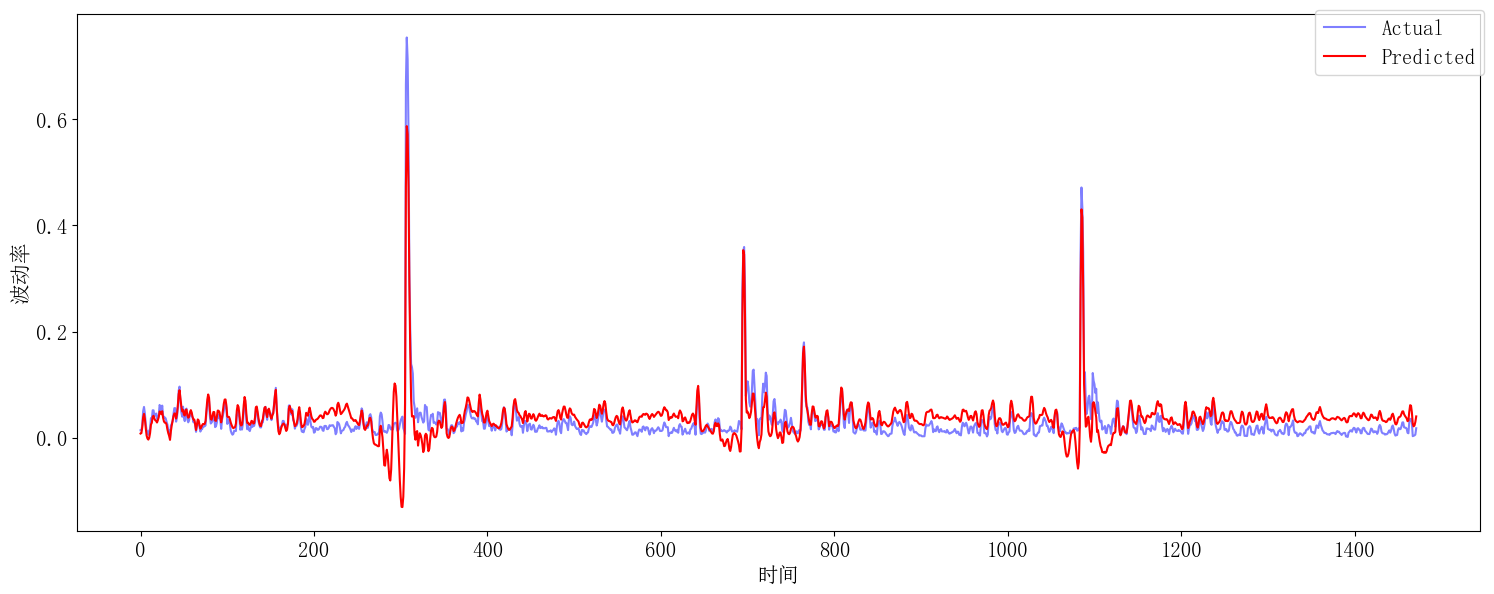

In [65]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# 绘制 Actual 曲线和 Predicted 曲线，共用同一个y轴
ax1.plot(li_rv_comp, label='Actual', alpha=0.5, color='blue')
ax1.plot(comb_emd['pred'], label='Predicted', color='red')
ax1.set_ylabel('波动率', fontsize = 15)

# 添加图例
fig.legend(loc="upper right",fontsize = 15)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('时间',fontsize = 15)
plt.tight_layout()
plt.show()

# LSTM

In [66]:
X = li.drop(columns=['rv'])
y = li['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 显示训练集和测试集的形状
print("训练集特征形状:", X_train.shape)
print("训练集目标形状:", y_train.shape)
print("测试集特征形状:", X_test.shape)
print("测试集目标形状:", y_test.shape)

训练集特征形状: (5885, 7)
训练集目标形状: (5885,)
测试集特征形状: (1472, 7)
测试集目标形状: (1472,)


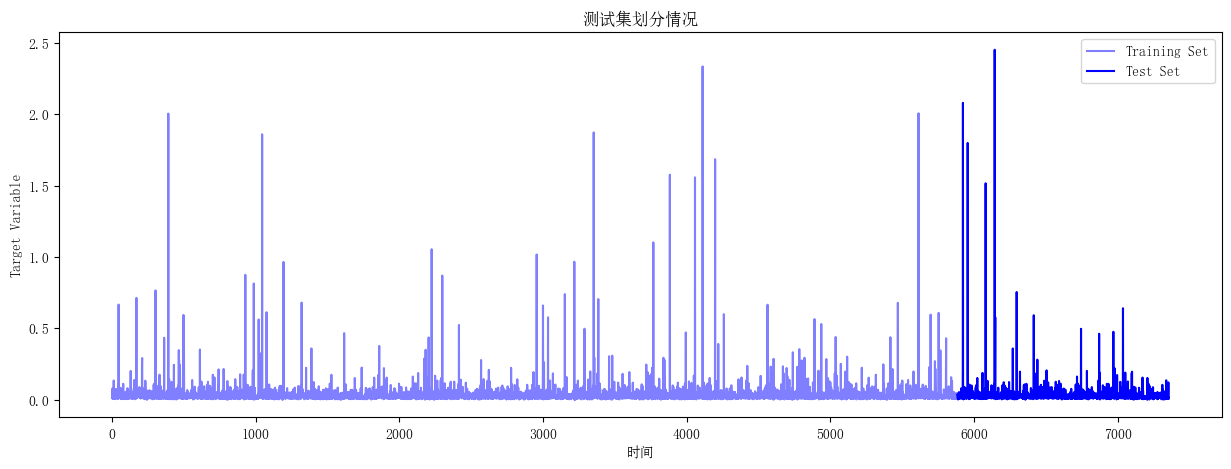

In [67]:
plt.figure(figsize=(15, 5))

# 绘制训练集目标变量曲线，设置 alpha 为 0.5
plt.plot(range(len(y_train)), y_train.values, label='Training Set', alpha=0.5, color='blue')

# 绘制测试集目标变量曲线
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test.values, label='Test Set', color='blue')

# 添加图例、标题和标签
plt.legend()
plt.title('测试集划分情况')
plt.xlabel('时间')
plt.ylabel('Target Variable')

plt.show()

## Model Training

In [68]:
li_his = model.fit(X_train, y_train,epochs=100, batch_size=64)

Epoch 1/100
92/92 [==============================] - 4s 6ms/step - loss: 0.0085
Epoch 2/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0084
Epoch 3/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0084
Epoch 4/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0085
Epoch 5/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0084
Epoch 6/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0084
Epoch 7/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0084
Epoch 8/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0084
Epoch 9/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0084
Epoch 10/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0084
Epoch 11/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0084
Epoch 12/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0084
Epoch 13/100
92/92 [=================

In [69]:
rv_pred = model.predict(X_test)

46/46 [==============================] - 1s 3ms/step


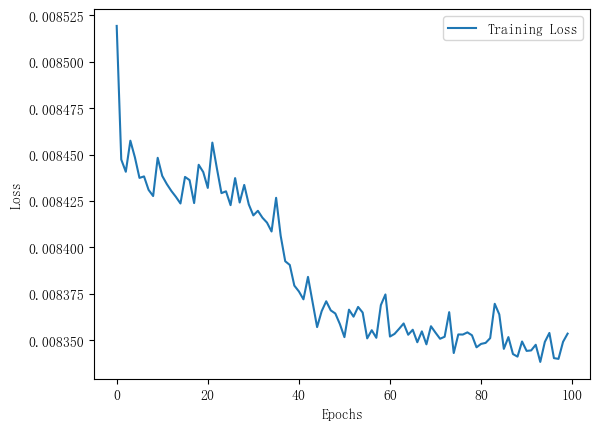

In [70]:
loss_rv = li_his.history['loss']
# 绘制训练曲线
plt.plot(loss_rv, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [71]:
rmse_rv = np.sqrt(mean_squared_error(y_test, rv_pred))
mae_rv = mean_absolute_error(y_test, rv_pred)

# 输出评估指标
print("RMSE:", rmse_rv)
print("MAE:", mae_rv)

RMSE: [0.11371271 0.11306381 0.11297685 ... 0.11445279 0.11297585 0.11473563]
MAE: tf.Tensor([0.03896283 0.03397063 0.03277318 ... 0.04281721 0.03275659 0.04408889], shape=(1472,), dtype=float32)


## Prediction Result

In [72]:
rv_pred = pd.DataFrame({'pred': rv_pred.reshape(-1)})
y_test = pd.DataFrame({'test': y_test}).reset_index(drop=True)
comb = pd.concat([rv_pred, y_test], axis=1)

comb.head()

,pred,test
0,0.052601,0.036995
1,0.045000,0.038013
2,0.042983,0.008943
3,0.048656,0.037719
4,0.051842,0.029006


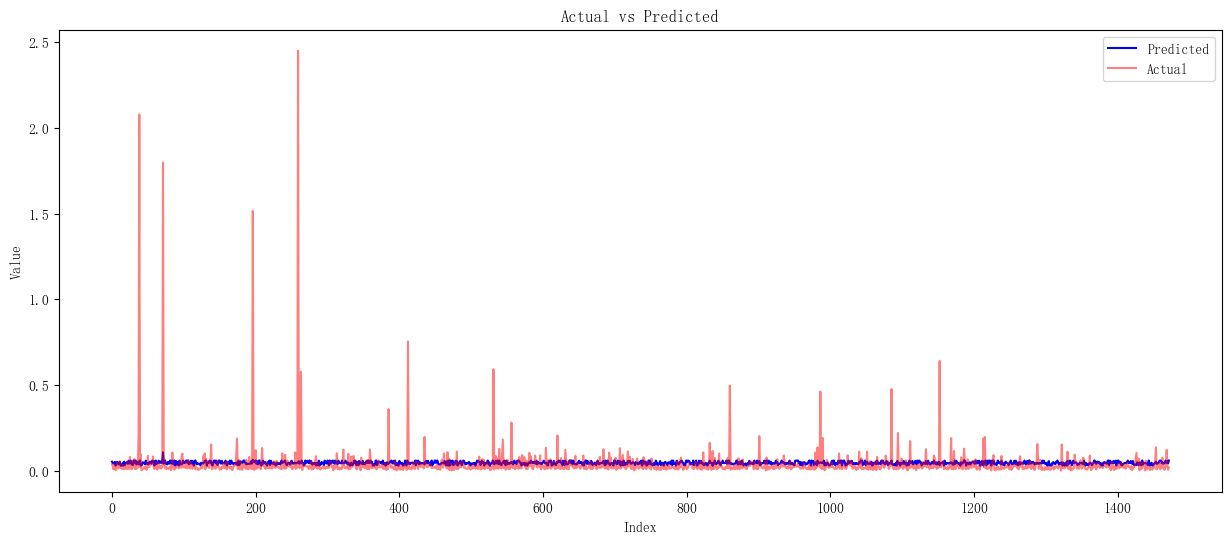

In [73]:
plt.figure(figsize=(15, 6))

plt.plot(comb['pred'], label='Predicted', color='blue')
plt.plot(comb['test'], label='Actual', color='red',alpha=0.5)

# 添加图例、标题和标签
plt.legend()
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')

plt.show()

# Value-at-Risk

## GARCH

首先，对收益率进行平稳性以及异方差检验

### ADF

In [75]:
ADF(li['return'])

Test Statistic,-29.126
P-value,0.000
Lags,7


### Engle

In [76]:
lishift=li['return'].shift(1).fillna(np.mean(li['return']))

In [77]:
eg_result = engle_granger(li['return'], lishift)

print('\nEngle-Granger Statistic: {:.4f}'.format(eg_result.stat))
print('p-value: {:.4f}'.format(eg_result.pvalue))
print('Null Hypothesis: {}'.format(eg_result.null_hypothesis))
print('Alternative Hypothesis: {}'.format(eg_result.alternative_hypothesis))


Engle-Granger Statistic: -47.0315
p-value: 0.0000
Null Hypothesis: No Cointegration
Alternative Hypothesis: Cointegration


### Spliting dataset

In [78]:
train_re, test_re = train_test_split(li['return'], test_size=0.2, shuffle=False)

In [79]:
print(train_re.shape)
print(test_re.shape)

(5885,)
(1472,)


D:\downloadposition\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


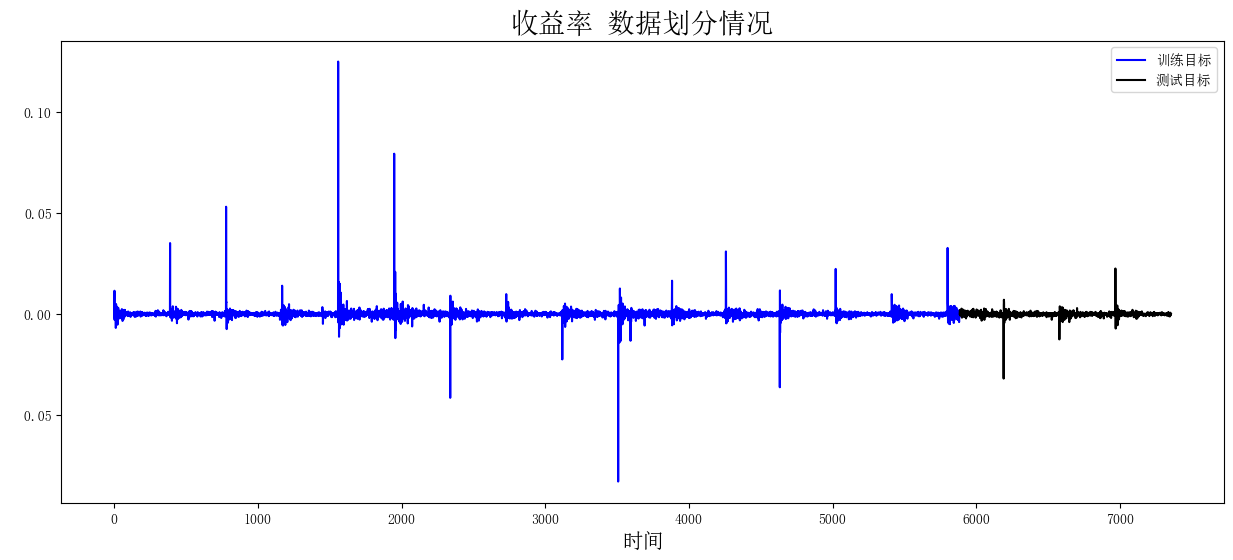

In [80]:
plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(train_re)), train_re, color='blue', label='训练目标')

plt.plot(np.arange(len(train_re), len(train_re) + len(test_re)),
         test_re, color='black', label='测试目标')

plt.title('收益率 数据划分情况', fontsize=20)
plt.xlabel('时间', fontsize=15)
plt.legend(loc='best')

locator = MultipleLocator(1000)
plt.gca().xaxis.set_major_locator(locator)
plt.show()

### Training model

In [81]:
def fit_vol_model(y, model_params, train_test_split = None):
    model = arch_model(y, **model_params)
    
    fitted = model.fit(disp = "off")
    train_y = y
        
    train_pred = fitted.conditional_volatility.dropna()
    train_resid = fitted.resid / train_pred
    
    return {
        "Test y": train_y,
        "Pred": train_pred,
        "Resid": train_resid,
        "Fitted": fitted,
        "Model": model
    }

garch_params = {"p": 1, "q": 1, "vol": "Garch", "dist": "skewt"}

In [82]:
vol_results = fit_vol_model(test_re*100, garch_params)

D:\downloadposition\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02004. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


### Vol Comparison with LSTM and EMD-LSTM

In [83]:
vol_test= pd.DataFrame(vol_results['Test y'])
vol_pred = pd.DataFrame(vol_results['Pred'])
vol_resid= pd.DataFrame(vol_results['Resid'])
res = vol_results['Fitted']
res

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                            return   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:                1735.66
Distribution:      Standardized Skew Student's t   AIC:                          -3459.32
Method:                       Maximum Likelihood   BIC:                          -3427.55
                                                   No. Observations:                 1472
Date:                           Wed, Apr 10 2024   Df Residuals:                     1471
Time:                                   08:12:36   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------

In [84]:
vol_pred_comp = vol_pred.reset_index(drop=True)

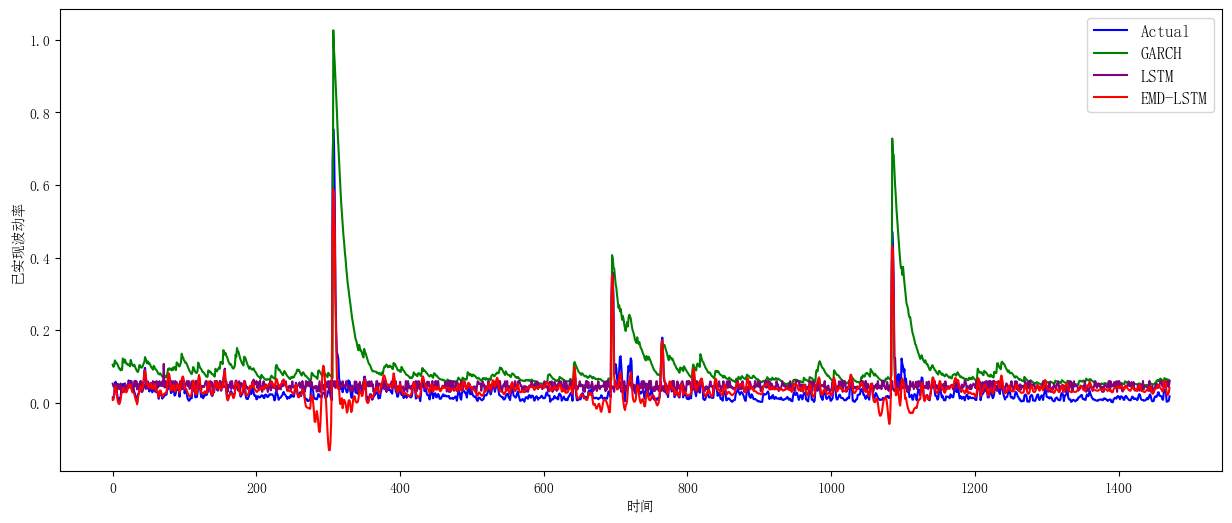

In [85]:
plt.figure(figsize=(15, 6))

# 绘制 Actual 曲线
plt.plot(li_rv_comp, label='Actual', color='blue')

# 绘制 GARCH 曲线
plt.plot(vol_pred_comp, label='GARCH', color='green')

# 绘制 LSTM 预测曲线
plt.plot(comb['pred'], label='LSTM', color='purple')

# 绘制 EMD-LSTM 曲线
plt.plot(comb_emd['pred'], label='EMD-LSTM', color='red')

# 添加图例、标题和标签，并调整图例的字体大小
plt.xlabel('时间')
plt.ylabel('已实现波动率')
plt.legend(prop={'size': 12})

# 显示图形
plt.show()

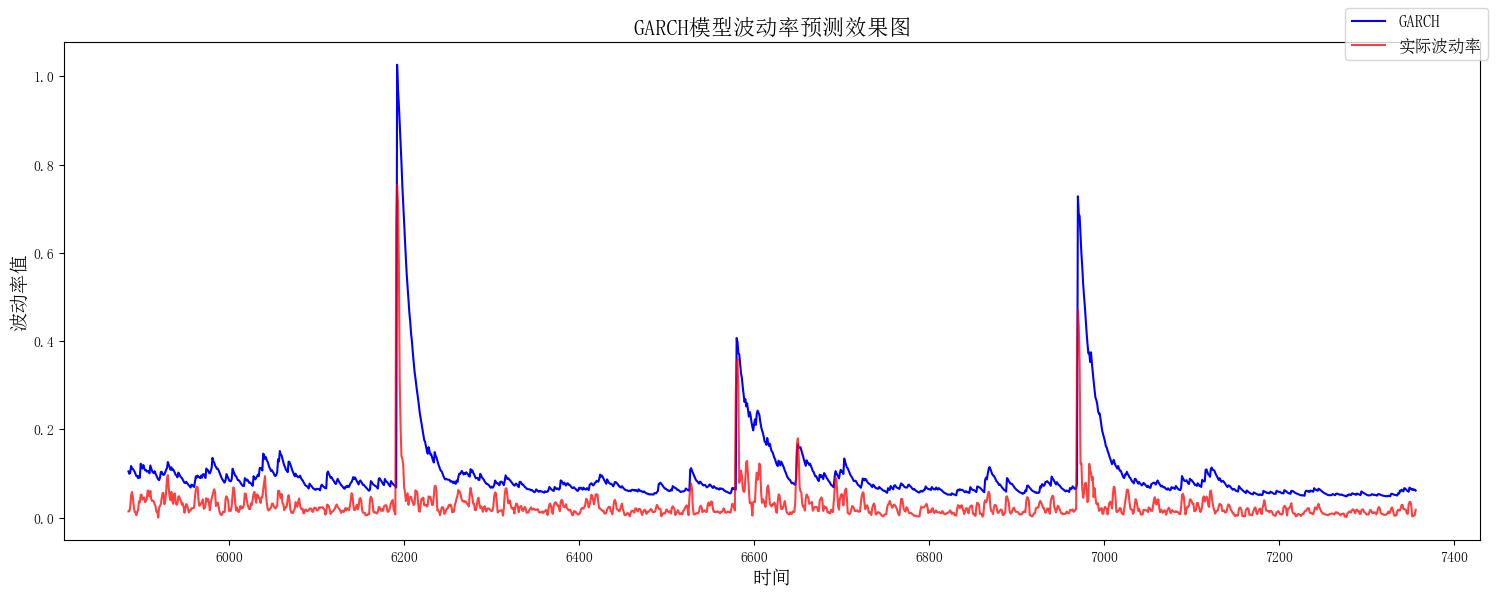

In [86]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# 绘制 vol_pred 列的数据
ax1.plot(vol_pred, label='GARCH', color='blue')
ax1.plot(li['rv'][5885:], label='实际波动率', color='red', alpha=0.75)

# 设置标签和标题
ax1.set_xlabel('时间', fontsize=14)
ax1.set_ylabel('波动率值', fontsize=14)
ax1.set_title('GARCH模型波动率预测效果图', fontsize=16)

# 添加图例
fig.legend(loc="upper right", fontsize='large')

plt.tight_layout()
plt.show()

### VaR Prediction

In [87]:
garch_params

{'p': 1, 'q': 1, 'vol': 'Garch', 'dist': 'skewt'}

In [88]:
res = vol_results['Fitted']

In [89]:
am = arch_model(li['return']*1000, p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')
res = am.fit(disp='off')

In [90]:
forecasts = res.forecast(start=5885)
cond_mean = forecasts.mean[:]
cond_var = forecasts.variance[:]
q = am.distribution.ppf([0.01, 0.05], res.params[5])
print(q)

[-2.65769035 -1.44767499]


In [91]:
print('cond_mean shape:', cond_mean.shape)
print('cond_var shape:', cond_var.shape)
print('q shape:', q.shape)

cond_mean shape: (1472, 1)
cond_var shape: (1472, 1)
q shape: (2,)


In [92]:
# 计算VaR
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=["1%", "5%"], index=cond_var.index)

In [93]:
value_at_risk

,1%,5%
5885,4.228489,2.301608
5886,4.070193,2.215382
5887,4.181835,2.276195
5888,3.944524,2.146928
5889,3.791197,2.063410
...,...,...
7352,1.869023,1.016379
7353,1.799936,0.978746
7354,1.843604,1.002533
7355,1.781693,0.968810


In [94]:
merged_df = pd.concat([li['return'][5885:]*1000, value_at_risk], axis=1)
merged_df.reset_index(drop=True, inplace=True)
merged_df

,return,1%,5%
0,0.129,4.228489,2.301608
1,1.151,4.070193,2.215382
2,2.058,4.181835,2.276195
3,-0.513,3.944524,2.146928
4,1.025,3.791197,2.063410
...,...,...,...
1467,0.662,1.869023,1.016379
1468,-0.042,1.799936,0.978746
1469,-0.619,1.843604,1.002533
1470,-0.132,1.781693,0.968810


C:\Users\Yueying Huang\AppData\Local\Temp\ipykernel_720\405475028.py:16: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
D:\downloadposition\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


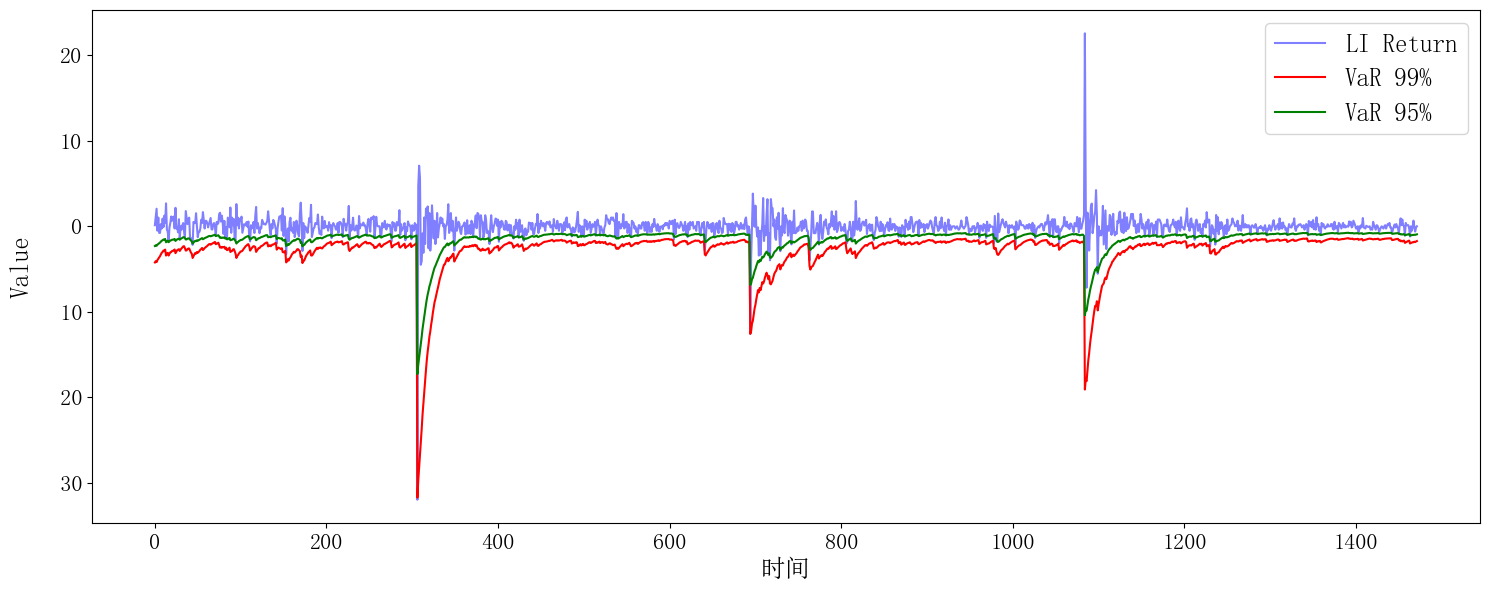

In [95]:
plt.figure(figsize=(15, 6))

# 绘制 LI Return 列
plt.plot(merged_df.index, merged_df['return'], label='LI Return', color='blue',alpha = 0.5)

# 绘制 Value at Risk 列
plt.plot(merged_df.index, -merged_df['1%'], label='VaR 99%', color='red')
plt.plot(merged_df.index, -merged_df['5%'], label='VaR 95%', color='green')

# 添加图例、标题和标签
plt.legend(fontsize=18)
plt.xlabel('时间',fontsize = 18)
plt.ylabel('Value',fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

D:\downloadposition\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


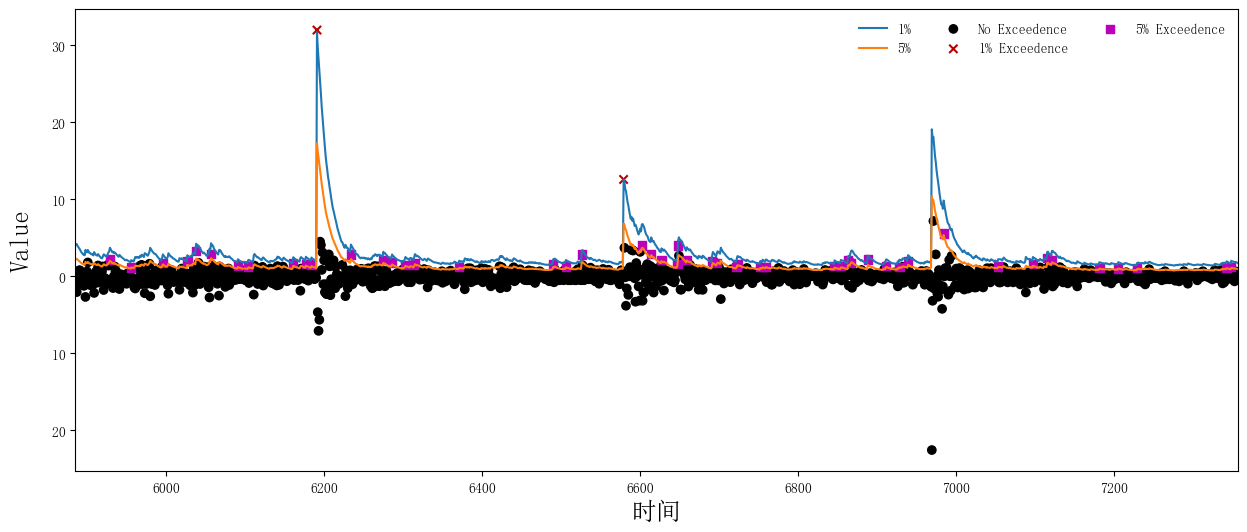

In [96]:
ax = value_at_risk.plot(legend=False, figsize=(15,6))
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])

rets = li['return'][5885:]*1000
rets.name = 'LI Return'

c = []
for idx in value_at_risk.index:
    if rets[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
        
c = np.array(c, dtype='object')

labels = {
    
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}

markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': 'o'}

for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets.index[sel],
        -rets.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
    
ax.legend(frameon=False, ncol=3)
plt.xlabel('时间',fontsize = 18)
plt.ylabel('Value',fontsize = 18)
plt.show()

## EMD-LSTM

OMG finally we're here! Feels like centries!

To calculate VaR, we need:

\begin{equation}
VaR_{t} = \mu_{t} + \sigma_{t} Z_{\alpha}
\end{equation}

where, Where $Z_{\alpha}$represents the critical value, $\mu_{t}$ denotes the average return of the underlying asset, and $\sigma_{t}$ is the estimated volatility. 

In [97]:
mu = cond_mean
sigma =pd.DataFrame(comb_emd['pred'])

print('mu:',type(mu))
print('sigma:',type(sigma))

mu: <class 'pandas.core.frame.DataFrame'>
sigma: <class 'pandas.core.frame.DataFrame'>


In [98]:
var_dl = -mu.values - sigma.values * q[None, :]
var_dl = pd.DataFrame(var_dl, columns=["1%", "5%"], index=sigma.index)

In [102]:
lire = li['return'][5885:]
lire.reset_index(drop = True, inplace =True)

In [103]:
dl = pd.concat([lire, var_dl], axis=1)
dl.reset_index(drop=True, inplace=True)
dl

,return,1%,5%
0,0.000129,0.016616,0.007351
1,0.001151,0.018941,0.008618
2,0.002058,0.048881,0.024927
3,-0.000513,0.097556,0.051440
4,0.001025,0.115371,0.061144
...,...,...,...
1467,0.000662,0.066612,0.034585
1468,-0.000042,0.052936,0.027135
1469,-0.000619,0.057135,0.029423
1470,-0.000132,0.074696,0.038988


### VaR Prediction

C:\Users\Yueying Huang\AppData\Local\Temp\ipykernel_720\846280363.py:16: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
D:\downloadposition\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


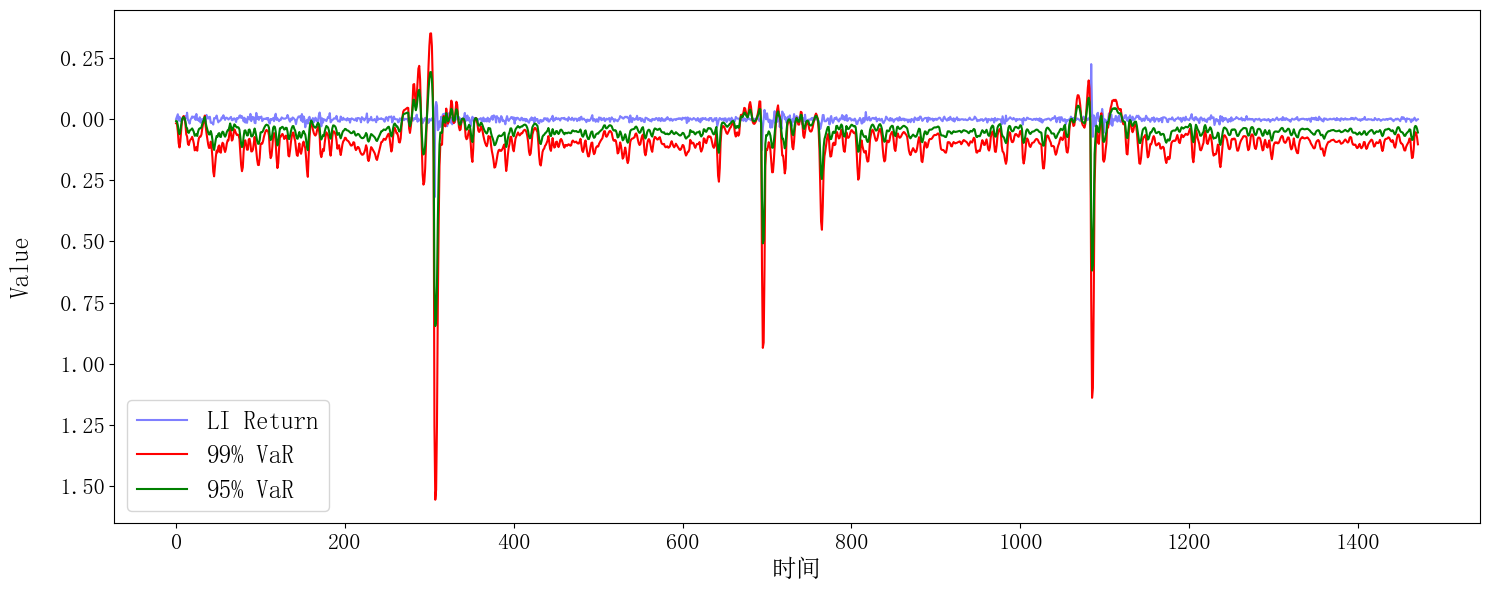

In [104]:
plt.figure(figsize=(15, 6))

# 绘制 LI Return 列
plt.plot(dl.index, dl['return']*10, label='LI Return', color='blue',alpha = 0.5)

# 绘制 Value at Risk 列
plt.plot(dl.index,-dl['1%'], label='99% VaR', color='red')
plt.plot(dl.index,-dl['5%'], label='95% VaR', color='green')

# 添加图例、标题和标签
plt.legend(fontsize=18)
plt.xlabel('时间',fontsize = 18)
plt.ylabel('Value',fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

D:\downloadposition\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


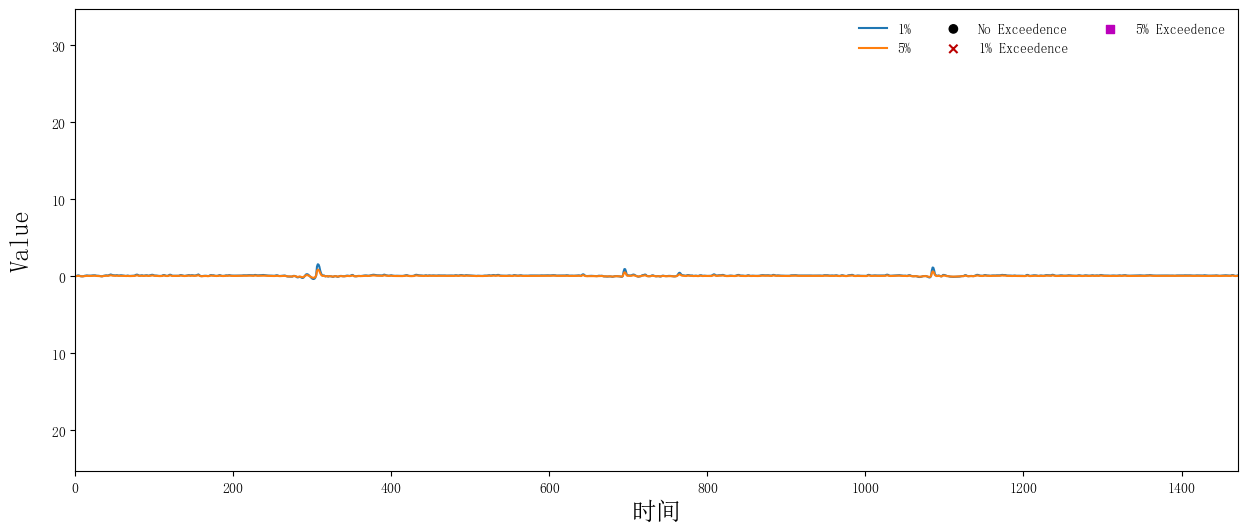

In [112]:
ax = var_dl.plot(legend=False, figsize=(15,6))
xl = ax.set_xlim(var_dl.index[0], var_dl.index[-1])

rets = li['return'][5885:]*1000
rets.name = 'LI Return'

c = []
for idx in value_at_risk.index:
    if rets[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
        
c = np.array(c, dtype='object')

labels = {
    
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}

markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': 'o'}

for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets.index[sel],
        -rets.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
    
ax.legend(frameon=False, ncol=3)
plt.xlabel('时间',fontsize = 18)
plt.ylabel('Value',fontsize = 18)
plt.show()

# Kupiec Test

I hate this part most...

Sometimes the outcomes are just frustrating...

But whatev. Let's just do it :)

In [106]:
def kupiec_test(actual_losses, var_predictions, confidence_level):
    # 计算失败次数
    failures = (actual_losses > var_predictions).sum()
    # 总观察次数
    total_obs = len(actual_losses)
    # 预期失败次数
    expected_failures = total_obs * (1 - confidence_level)
    # 计算似然比统计量
    lr_stat = -2 * np.log(binom.pmf(failures, total_obs, 1 - confidence_level)) + 2 * np.log(binom.pmf(failures, total_obs, 1 - failures / total_obs))
    # 计算卡方分布的临界值
    critical_value = chi2.ppf(1 - confidence_level, 1)

    return lr_stat,critical_value,failures

In [107]:
actual_losses = li['return'][5885:].reset_index(drop=True)
actual_losses

0       0.000129
1       0.001151
2       0.002058
3      -0.000513
4       0.001025
          ...   
1467    0.000662
1468   -0.000042
1469   -0.000619
1470   -0.000132
1471    0.000000
Name: return, Length: 1472, dtype: float64

## 95%

### EMD-LSTM

In [108]:
var_predictions = np.squeeze(sum_pred)
confidence_level = 0.95
# 进行 Kupiec 检验
lr_stat, critical_value,failures = kupiec_test(actual_losses, var_predictions, confidence_level)

print("Likelihood Ratio Statistic:", lr_stat)
print("Critical Value:", critical_value)
print("failures", failures)
print("Reject null hypothesis?" , "Yes" if lr_stat > critical_value else "No")

Likelihood Ratio Statistic: -inf
Critical Value: 0.003932140000019531
failures 100
Reject null hypothesis? No


C:\Users\Yueying Huang\AppData\Local\Temp\ipykernel_720\1094737545.py:9: RuntimeWarning: divide by zero encountered in log
  lr_stat = -2 * np.log(binom.pmf(failures, total_obs, 1 - confidence_level)) + 2 * np.log(binom.pmf(failures, total_obs, 1 - failures / total_obs))


### GARCH

In [109]:
var_predictions = merged_df['5%']
confidence_level = 0.95

# 进行 Kupiec 检验
lr_stat, critical_value,failures = kupiec_test(actual_losses, var_predictions, confidence_level)

# 输出结果
print("Likelihood Ratio Statistic:", lr_stat)
print("Critical Value:", critical_value)
print("failures", failures)
print("Reject null hypothesis?" , "Yes" if lr_stat > critical_value else "No")

Likelihood Ratio Statistic: -inf
Critical Value: 0.003932140000019531
failures 0
Reject null hypothesis? No


C:\Users\Yueying Huang\AppData\Local\Temp\ipykernel_720\1094737545.py:9: RuntimeWarning: divide by zero encountered in log
  lr_stat = -2 * np.log(binom.pmf(failures, total_obs, 1 - confidence_level)) + 2 * np.log(binom.pmf(failures, total_obs, 1 - failures / total_obs))


## 99%

### EMD-LSTM

In [110]:
var_predictions = np.squeeze(sum_pred)
confidence_level = 0.99

# 进行 Kupiec 检验
lr_stat, critical_value,failures = kupiec_test(actual_losses, var_predictions, confidence_level)

# 输出结果
print("Likelihood Ratio Statistic:", lr_stat)
print("Critical Value:", critical_value)
print("failures", failures)
print("Reject null hypothesis?" , "Yes" if lr_stat > critical_value else "No")

Likelihood Ratio Statistic: -inf
Critical Value: 0.00015708785790970235
failures 100
Reject null hypothesis? No


C:\Users\Yueying Huang\AppData\Local\Temp\ipykernel_720\1094737545.py:9: RuntimeWarning: divide by zero encountered in log
  lr_stat = -2 * np.log(binom.pmf(failures, total_obs, 1 - confidence_level)) + 2 * np.log(binom.pmf(failures, total_obs, 1 - failures / total_obs))


### GARCH

In [111]:
var_predictions = merged_df['1%']
confidence_level = 0.99

# 进行 Kupiec 检验
lr_stat, critical_value, failures = kupiec_test(actual_losses, var_predictions, confidence_level)

# 输出结果
print("Likelihood Ratio Statistic:", lr_stat)
print("Critical Value:", critical_value)
print("failures", failures)
print("Reject null hypothesis?" , "Yes" if lr_stat > critical_value else "No")

Likelihood Ratio Statistic: -inf
Critical Value: 0.00015708785790970235
failures 0
Reject null hypothesis? No


C:\Users\Yueying Huang\AppData\Local\Temp\ipykernel_720\1094737545.py:9: RuntimeWarning: divide by zero encountered in log
  lr_stat = -2 * np.log(binom.pmf(failures, total_obs, 1 - confidence_level)) + 2 * np.log(binom.pmf(failures, total_obs, 1 - failures / total_obs))


# 致谢

这篇论文是金融学主修学位的毕业论文。

老实说，首先要感谢自己辅修了应用统计学的学位，不然毕业论文选题不知道要怎么办才能叫本科生创新。当然这也给了我一个启发：如果你想要在现有的专业领域里有新的路子可以走，学多点，学杂点，总归是好的。

比如在我的同系的同学们最多用Python简单数据分析的时候，我可以直接手搓一个深度学习模型来完成我的毕业论文，虽然对于真正这个领域的同学来说简直是班门弄斧。

但至少我有机会看见新的世界，以及新的可能性 :)

辅修的代码不出意外也会进行上传，那篇复杂度略高于这一篇，虽然模型选取对于我的指标来说有点杀鸡用牛刀的感觉 :/

总之，谢谢的想法已经在另一篇里道尽了，写完这一篇反而有种如释重负的感觉。

但我还是很感谢一直以来陪伴我走到这里的人。

我从前是个不在意他人感受，我行我素的人；是一个不懂得体会身边亲近的人的情绪，淡漠的人。

但因为这些朋友的存在，让我学会了如何去好好爱身边的人，好好去表达以及接受这些爱意，珍视每一份难得的心意。

虽然我依旧是一个糟糕的人，但谢谢你们，因为你们的存在让我感觉我没有糟糕到无药可救。 :3

<div style="text-align: right;">
歪，2024年4月。
</di月留